### Installations

In [ ]:
!pip install datasets evaluate rouge_score py7zr --quiet
!pip install accelerate -U --quiet

In [ ]:
!kaggle datasets download -d gunman02/health-care-magic
!unzip /content/health-care-magic.zip -d /content/drive/MyDrive/CareConnect/raw_data/

### Set up

In [ ]:
import gc
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datasets import load_dataset
import torch
from torch.utils.data import Subset
from transformers import (
      AutoTokenizer, pipeline,
      DataCollatorWithPadding,
      AutoModelForSpeechSeq2Seq,
      BartForConditionalGeneration,
      TrainingArguments,
      Seq2SeqTrainingArguments,
      Trainer
)
import evaluate
from tqdm.auto import tqdm
import warnings

warnings.filterwarnings("ignore")

In [ ]:
seed = 42
np.random.seed(seed)

### Loading Health Care Magic Dataset

In [ ]:
HMCDataset = load_dataset('json',data_files='/content/drive/MyDrive/CareConnect/raw_data/HealthCareMagic-100k.json')
HMCDataset = HMCDataset['train'].train_test_split(train_size=0.8,seed=seed)
HMCDatasetTemp = HMCDataset['test'].train_test_split(train_size=0.5,seed=seed)
HMCDataset['validation'] = HMCDatasetTemp.pop('train')
HMCDataset['test']  = HMCDatasetTemp.pop('test')
del HMCDatasetTemp
HMCDataset

DatasetDict({
    train: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 89732
    })
    test: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 11217
    })
    validation: Dataset({
        features: ['instruction', 'input', 'output'],
        num_rows: 11216
    })
})

In [ ]:
HMCDataset['train'][0]

{'instruction': "If you are a doctor, please answer the medical questions based on the patient's description.",
 'input': 'im a 39yr old female,i just had a spinal fusion surgery on my back in December. in December I missed my period,january comes I get my period but its really heavy and then I started vomiting for 8 days straight when my period was over s were my symptoms, then febuary comes same thing I get my period and vomit for 8 days again,now march just before my period started I vomited for 8 days then my period started and I vomited for another few days . ive been hospitalized for dehydration 5 times since jan. before my back surgery I was on a high dose of morphine for pain but im off it now and have been for 6 weeks my dr thought it could be my receptors in my brain he also said I didnt have any of my own endorphins to fight pain so I need to work on building them back up.but even now my dr is confused by my symtoms and is now sending me for a colonoscopy ive already had an 

### Data Exploration

In [ ]:
# Creating a list of document lengths and counter of words
input_length_distribution = []
output_length_distribution = []
input_word_distribution = {}

for data in tqdm(HMCDataset['train']):
    input_text = data['input']
    output_text = data['output']
    input_length_distribution.append(len(input_text))
    output_length_distribution.append(len(output_text))
    for word in input_text.split():
        if word not in input_word_distribution:
            input_word_distribution[word] = 1
        else:
            input_word_distribution[word] += 1

  0%|          | 0/89732 [00:00<?, ?it/s]

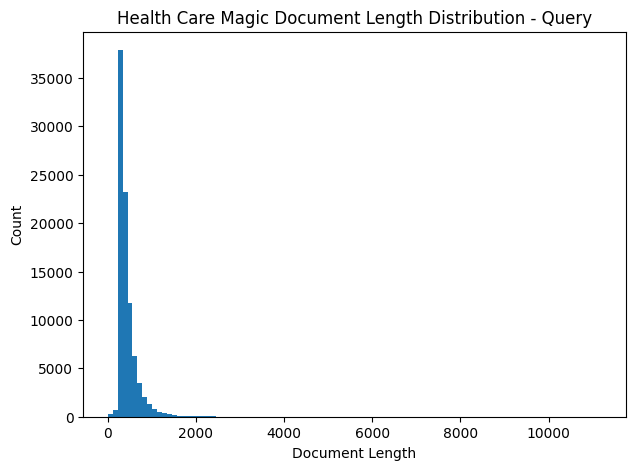

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Health Care Magic Document Length Distribution - Query')
plt.xlabel('Document Length')
plt.ylabel('Count')
plt.hist(input_length_distribution, bins=100)
plt.show()

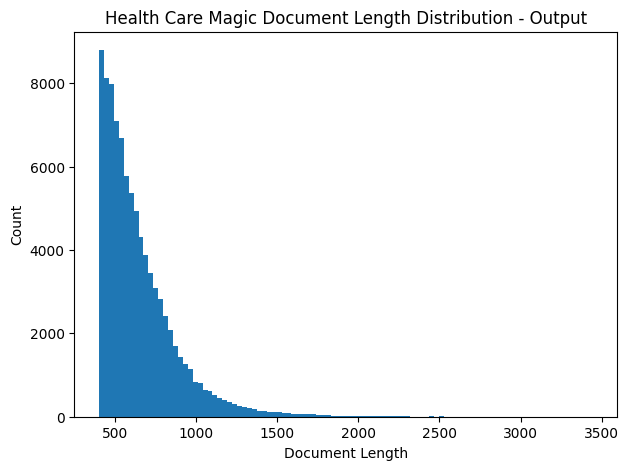

In [ ]:
plt.figure(figsize=(7,5))
plt.title('Health Care Magic Document Length Distribution - Output')
plt.xlabel('Document Length')
plt.ylabel('Count')
plt.hist(output_length_distribution, bins=100)
plt.show()

In [ ]:
# Most common words
print('Health Care Magic Most Common Words')
sorted_word_count = sorted(list(input_word_distribution.items()), key=lambda x: -x[1])[:20]
pd.DataFrame(sorted_word_count, columns=['Word', 'Count'])

Health Care Magic Most Common Words


,Word,Count
0,I,249639
1,and,236694
2,the,181133
3,a,163347
4,to,157813
5,my,154172
6,is,116192
7,of,104468
8,have,101832
9,i,91610


### Load MedAlpaca Dataset

In [ ]:
MedAlpacaDataset = load_dataset('medalpaca/medical_meadow_medical_flashcards')
MedAlpacaDataset

Generating train split:   0%|          | 0/33955 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['input', 'output', 'instruction'],
        num_rows: 33955
    })
})

In [ ]:
MedAlpacaDataset['train'][0]

{'input': 'What is the relationship between very low Mg2+ levels, PTH levels, and Ca2+ levels?',
 'output': 'Very low Mg2+ levels correspond to low PTH levels which in turn results in low Ca2+ levels.',
 'instruction': 'Answer this question truthfully'}

### Data Exploration

In [ ]:
# Creating a list of document lengths and a counter of words
input_length_distribution = []
output_length_distribution = []
input_word_count = {}

for data in tqdm(MedAlpacaDataset['train']):
    input_text = data['input']
    output_text = data['output']
    input_length_distribution.append(len(input_text))
    output_length_distribution.append(len(output_text))
    for word in input_text.split():
        if word not in input_word_count:
            input_word_count[word] = 1
        else:
            input_word_count[word] += 1

  0%|          | 0/33955 [00:00<?, ?it/s]

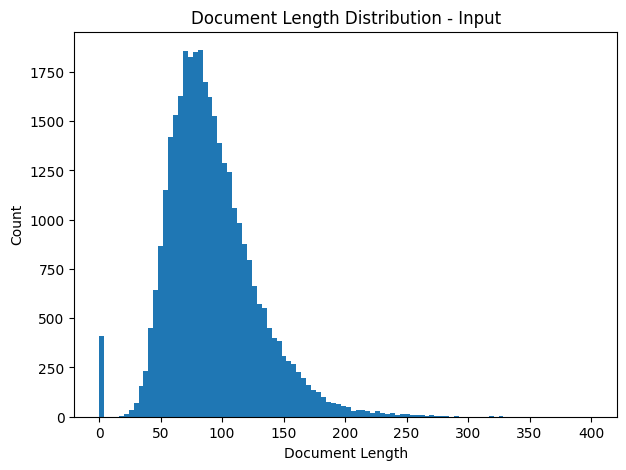

In [ ]:

plt.figure(figsize=(7, 5))
plt.title('Document Length Distribution - Input')
plt.xlabel('Document Length')
plt.ylabel('Count')
plt.hist(input_length_distribution, bins=100)
plt.show()

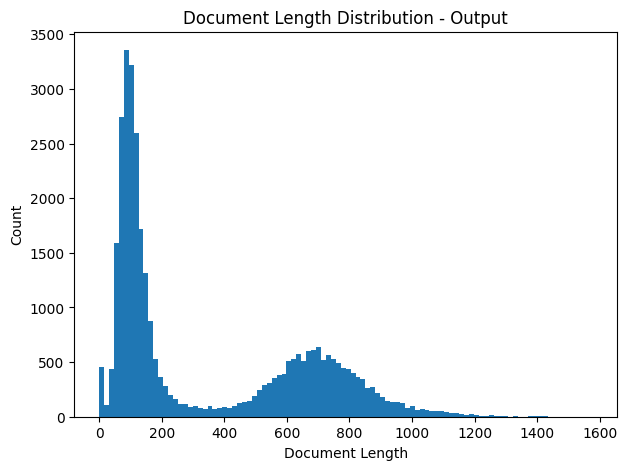

In [ ]:
plt.figure(figsize=(7, 5))
plt.title('Document Length Distribution - Output')
plt.xlabel('Document Length')
plt.ylabel('Count')
plt.hist(output_length_distribution, bins=100)
plt.show()

In [ ]:
# Most common words
sorted_word_count = sorted(list(input_word_count.items()), key=lambda x: -x[1])[:20]
pd.DataFrame(sorted_word_count, columns=['Word', 'Count'])

,Word,Count
0,the,33590
1,is,25537
2,of,24198
3,What,23827
4,and,14887
5,in,9603
6,are,8102
7,a,7809
8,to,7212
9,with,7069


### Preprocessing

In [ ]:
promptTemplateOne = '''
                    ### SYSTEM: You are CareConnect, an expert medical personal assistant.

                    ### INSTRUCTION: Answer the user's queries truthfully and accurately, based on the provided context if they seem relevant. Refuse to answer any questions unrelated to medicine.

                    ### CONTEXT: {context}

                    ### USER: {user_query}

                    ### Assistant:
                    '''

In [ ]:
device = 0 if torch.cuda.is_available() else -1
cnnBart = pipeline("summarization", model="facebook/bart-large-cnn",device=device)
amiBart = pipeline("summarization", model="knkarthick/MEETING_SUMMARY",device=device)

In [ ]:
pattern = re.compile(f'chat\s*doctor',re.IGNORECASE)
def preprocess(batch):
    replacement = 'CareConnect'
    prefix = 'Hi, Welcome to CareConnect.  '
    return {'processed_output': [pattern.sub(replacement,output) for output in batch['output']],
            'cnnBart_output': [pattern.sub(replacement,summary['summary_text']) for summary in cnnBart(batch['output'], do_sample=False)],
            'amiBart_output': [pattern.sub(replacement,summary['summary_text']) for summary in amiBart(batch['output'], do_sample=False)],
            'cnnBart_input': [pattern.sub(replacement,summary['summary_text']) for summary in cnnBart(batch['input'], do_sample=False)],
            'amiBart_input': [pattern.sub(replacement,summary['summary_text']) for summary in amiBart(batch['input'], do_sample=False)],

            }

In [ ]:
testing_data = HMCDataset['test'].select(range(20)).map(preprocess,batched=True)
testing_data

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.colheader_justify', 'left')

pd.DataFrame({
    'Input': testing_data['input'][:20],
    'CNN BART Input': testing_data['cnnBart_input'][:20],
    'Ami BART Input': testing_data['amiBart_input'][:20]
})

,Input,CNN BART Input,Ami BART Input
0,i have little pain in my testicles sometimes i feel too much pain that i can t walk along the way and when my penis stand after that i feel so much pain...there is no swollen in testicle but when i touch it becomes painful...it s about one year ago started but sometimes i feel pain..please kindly tell me what is happening with me,i have little pain in my testicles sometimes i feel too much pain that i can't walk along the way and when my penis stand after that i feel so much pain...there is no swollen in testicle but when i touch it becomes painful...it s about one year ago started but sometimes i feels pain..please kindly tell me what is happening with me.,Sometimes I feel too much pain in my testicles and I can't walk. It started about a year ago.
1,"hi i m khyati...... lives in bangalore....... i m suffering from chest congestion, i have difficulty in breathing but after nabulisation i feel little comfortable ..........but a lot of weekness....................doctors gave me tab. advent625, tab. glemontF, syp. mucolite and tab. ato z. it happen when there are clouds outside ..........do i need to take something else wat precaution should i take to avoid this thing. pls suggest.","i m suffering from chest congestion, i have difficulty in breathing.doctors gave me tab. advent625, tab. glemontF, syp. mucolite and tab. ato z. it happen when there are clouds outside.do i need to take something else wat precaution should i take to avoid this thing. pls suggest.",Khyati lives in bangalore. She has chest congestion. She got medicine tabs.
2,I have been treated by my dentist for 4 weeks now for an extremely sore palate . She tells me taht she sees my palatal rugae are inflamed but that there is no sign of specific ulceration/ broken skin but has treated me unsuccessfully for bacterial/ then fungal and finally steroid lozenges to no avail!! Nothing is working. She has also cured my gingival bleeding condition and instilled me with better oral hygiene measures - using interdental brushes and corsodyl but my palate is still agony. She thinks it might eb an allergy but what do you think. Its soooo painful!!!,I have been treated by my dentist for 4 weeks now for an extremely sore palate. She has treated me unsuccessfully for bacterial/ then fungal and finally steroid lozenges to no avail!! Nothing is working. She thinks it might eb an allergy but what do you think. Its soooo painful!!!,My palate is very sore. I have been to the dentist 4 times in the last 4 weeks and nothing seems to be helping.
3,I am 22yrs old and presently suffering from severe hair loss . They fall the moment i touch them softly even and its scary when I find then on the floor after I comb. Earlier I had used Hair 4 U tropical solution 2% in 2009 and had recovered from the problem then and again suddenly find my condition more worst than what I had suffered then during these days and with a dermatologist consultation I am asked to continue my treatment with Amexidil 5 (ranbaxy) . It has been a month I am using it but yet no control on hair fall rather I feel depressed to find same excessive hair loss. Please help me,I am 22yrs old and presently suffering from severe hair loss. They fall the moment i touch them softly even and its scary when I find then on the floor after I comb. Earlier I had used Hair 4 U tropical solution 2% in 2009 and had recovered from the problem then and again suddenly find my condition more worst.,Hair 4 U tropical solution 2% in 2009 helped me with hair loss. Now I am having problems with hair fall. Dermatologist asked me to continue with Amexidil 5 (ranbaxy) for a month.
4,I have cysts multiple subcentimeter lymph nodes in the left axillary region. Could you explain where and exactly what this means. I have paperwork that states that my coronary arteries appear grossly perfused and sections of the lung demonstrate a tiny subpleural 0.5 cm nonsolid opacity within the anterior aspect of the right middle 

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.colheader_justify', 'left')

pd.DataFrame({
    'Processed Output': testing_data['processed_output'][:20],
    'CNN BART Output': testing_data['cnnBart_output'][:20],
    'Ami BART Output': testing_data['amiBart_output'][:20]
})

,Processed Output,CNN BART Output,Ami BART Output
0,Hi dear. I understand your concern. Pain in testis need to be evaluated by color Doppler. It could be trauma or infection or varicocele etc. Color Doppler will give more confirmation. Proper physical examinations and investigation will help to rule out pathology like orchids or epididymis orchids or varicocele. Consult neurosurgeon and get help. Still if you have a query then feel free to ask. Happy to help you further. Thank you.,Pain in testis need to be evaluated by color Doppler. It could be trauma or infection or varicocele etc. Proper physical examinations and investigation will help to rule out pathology like orchids or epididymis. Consult neurosurgeon and get help.,The pain in testis can be diagnosed using color doppler. Consult a neurosurgeon.
1,"Hi, Welcome to CareConnectAfter going through history because there is seasonal association, Bronchial asthma is possible your treatment also suggest that possibility. Another possibility is post viral acute bronchitis. You can get PFT pulmonary function test when you are not taking CareConnect. A detail alley work may be done including serum IGE level and allergy testing then specific allergen can be DE sensitized or avoided. In general exposure to pollen, dust,fungus pet animal can be avoided. Increase your immunity and lung capacity by taking yoga and Panama and exercises. One can avoid sudden changes in temperatures like AC rooms and going outside. Take your inhalers as advised by doctor and take care of your diet also if overweight reduce it and avoid fermented foods and any specific food which increases your problematize care Good luck to you.","After going through history because there is seasonal association, Bronchial asthma is possible your treatment also suggest that possibility. Another possibility is post viral acute bronchitis. Increase your immunity and lung capacity by taking yoga and Panama and exercises. One can avoid sudden changes in temperatures like AC rooms and going outside. Take your inhalers as advised by doctor and take care of your diet.","After going through history, Bronchial asthma is possible. You can get PFT pulmonary function test when you are not taking CareConnect. If you are overweight, reduce your intake of fermented foods and avoid certain triggers."
2,"Hello, Thanks for writing to us. Soreness on palate can be due to-1. Denture dermatitis caused due to dentures or appliances inserted.2.abscess developed due to spread of infection into periapical area through deep caries or periodontal infection. I would suggest you to get a thorough clinical evaluation done. Discontinue use of appliances or dentures causing allergy. Pus if present has to be CareConnect. Take care.",Denture dermatitis caused due to dentures or appliances inserted.abscess developed due to spread of infection into periapical area through deep caries or periodontal infection. Discontinue use of appliances or dentures causing allergy. Pus if present has to be removed.,Soreness on palate can be due to-1. Denture dermatitis caused by dentures or appliances inserted. 2. An abscess developed due to deep caries or periodontal infection.
3,"Hi there.1. Your concern is halogen effluvium.2. don't worry it's a temporary recoverable hair loss.3. You can try songstress serum, apply 5 sprays once daily bedtime.4.shampoo the hair with kaboom anti hair loss shampoo weekly twice with soft CareConnect. 5. try pronged tab daily one after breakfast. Continue them until hair fall controlled then you can shift to minoxidil 2% molecule. Hope this will help you","You can try songstress serum, apply 5 sprays once daily bedtime. Shampoo the hair with kaboom anti hair loss shampoo weekly twice with soft CareConnect. Try pronged tab daily one after breakfast. Continue them until hair fall controlled then you can shift to minoxidil 2% molecule.","Hair loss is caused by halogen effluvium. To prevent it, you can use songstress serum, apply 5 sprays onc

In [ ]:
HMCDataset = HMCDataset.remove_columns(['instruction'])
HMCDataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 89732
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 11217
    })
    validation: Dataset({
        features: ['input', 'output'],
        num_rows: 11216
    })
})

In [ ]:
pattern = re.compile(f'chat\s*doctor',re.IGNORECASE)
def finPreprocess(batch):
    replacement = 'CareConnect'
    prefix = 'Hi, Welcome to CareConnect.  '
    return {
            'preprocessed_output': [pattern.sub(replacement,output) for output in batch['output']],
            'summarized_input': [pattern.sub(replacement,summary['summary_text']) for summary in amiBart(batch['input'], do_sample=False)],
            'summarized_ouput': [pattern.sub(replacement,summary['summary_text']) for summary in amiBart(batch['output'], do_sample=False)],
            }

In [ ]:
HMCDatasetProcessed = HMCDataset.map(finPreprocess,batched=True,batch_size=10000)
HMCDatasetProcessed

In [ ]:
HMCDatasetProcessed.to_json('/content/drive/MyDrive/CareConnect/processed_data/processedHCM_100K.json')

**NOTES**

Ways to tune RAG
1.
- Fine-tune on HCM/MedAlpaca by varying the amount of context provided. Eg. None, Sliced window.
- Evaluation create a vector db of question linking to corresponding answers and add the context.
2.
- Fine-tune on MedAlpaca by providing an abstractive summary of the conversation as the context. Eg. None, Sliced window.
3.
- Fine-tune on HCM using MedAlpaca as vector db while giving corresponding contexts.

Ideas:
1. Add the prompt in the tokenize function and before tokenization.
2. Add synthetic data for:     
   a. Prevent irrelevant questions.
   b. Thank you greetings.
3. Have the output go through some sort of parser or another model to get visually pleasing outputs.


Questions:
1. Which type of RAG mentioned above is more effective?
2. Is it better to fine tune with formats or after for model efficiency?

